What are GANS?

GANs is a Machine learning model that is composed of two neural networks where each network tries to become more accurate than the other network with respect to predictions.
The generator and the discriminator are the two neural networks that make up a GAN. The generator represents convolutional neural network and the discriminator represents deconvolutional neural network. GANs begin to generate outputs with high quality to deceive discriminator and discriminator becomes better at finding out the data that has been created artificially by the generator.
Generator and discriminator have two different goals. The first (generator) aims to generate fake data to deceive the discriminator and maximize the overall loss function. The discriminator goal is to discriminate between real 
and fake data and to minimize the overall loss function.


In the procedure of training,the generator becomes better at generating images that look very near to real, while the discriminator becomes better at discovering fake images. The procedure reaches equilibrium point when the discriminator can no longer discriminate real images from fakes.



The Difference between the Simple GAN and DCGAN

Simple GAN:the generator in a simple GAN is a  fully connected network.

The DCGAN (Deep Convolutional Generative adversarial Network),it is composed mainly of convolutional layers and strides for usampling and down sampling of 2D image without Max pooling or fully connected layers.

where the upsampling increases the sampling rate and increases the block resolution
but downsampling descreases the sampling rate and decreases dimensionality features which lead to the loss of some information

DCGAN Method of working
First replace all max pooling with convolutional stride.Then use transposed convolution for upsampling.After that eliminate the fully connected layers.
Then use Batch normalization except the output layer for the generator and the input layer of the discriminator.Use ReLU in the generator for activation except for the output which uses tanh.And finally use LeakyReLU in the discriminator as activation function.

As a first step we statrted with getting the needed imports we use Colab as it 
already has most of the machine learning libraries pre-installed, and therefore, we can just import them



In [ ]:
import tensorflow as tf
tf.__version__
'2.8.0-rc1'
import glob           # The glob module is used for Unix style pathname pattern expansion
import imageio        # The library that provides an easy interface to read and write a wide range of image data

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
# In order to be able to generate GIFs for better visualization
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9h1kfax2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-9h1kfax2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=d1912037af8b4528cd1b5cc6ca285d5a831fc59bc09f16afd58f6d4d533f8e0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-__csgkvh/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


 We used here the MNIST dataset which contains 60000 images for training and   10000 images for testing.we get the dataset from Tensorflow library,by this way we have a preprocessed version of the dataset.


Why we use keras:
It is an** open-source** neural network library is designed to provide fast experimentation with deep neural networks,run on top of tensorflow and **user friendly**

why we use Tensorflow:
TensorFlow is an end-to-end **open-source deep learning framework** developed by Google.It provides **multiple abstraction levels for building and training models**.It offers also a **flexible,** comprehensive ecosystem of community resources, libraries, and tools that facilitate building and deploying machine learning apps.

In [ ]:
(t_images, t_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


After loading the preprocessed version of the dataset ,We have to make some steps to fit our data into the GAN model. Therefore, in the second line, we separate these two groups as train and test and also separated the labels and the images.

Train and test parts contain greyscale RGB(red,green and blue) codes (from 0 to 255) while other train and test parts contain labels from 0 to 9 which represents which number they actually are. 

we are working with unsupervised learning task where data are not labelled.


For more efficient and effective training of data we convert the Numpy array into Tensorflow dataset.

In [ ]:
t_images = t_images.reshape(t_images.shape[0], 28, 28, 1).astype('float32') #28*28 size of image, 1 for grey images
t_images = (t_images - 127.5) / 127.5  #image normalization, t_images represents train images
BUFFER_SIZE=60000     #size of training dataset
BATCH_SIZE=10        #number of images in one epoch
#convert Numpy array into tensorflow dataset for efficient and effective training
t_dataset=tf.data.Dataset.from_tensor_slices(t_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Then we create our generator model

**Input for the generator model**:Dense layer takes input seed(which is the random noise) 

**The need for transposed convolution layes** appears as these layes help increase the size of a small array and this step is needed after reshaping of our 1D array into 2D array.

We used **BatchNormalization technique** is used to accelearte the training process of neural network and help to improve  the model performance via a modest regularization effect.

**Target of generator model**:The generator takes input of 1 dimension arrays and generates output which is 28×28 pixel images.


As a summary
The generator uses tf.keras.layers.Conv2DTranspose upsampling layers to produce an image from a seed which is random noise.starting from Dense layer that takes this random noise as an input, and then upsample this seed several times until reaching the desired image with size  28x28x1. All layers use tf.keras.layers.LeakyReLU activation but the outer layer uses tanh activation.

generator model is built using Keras Sequential API.



In [ ]:
def generator_model():

    

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 100 is shape of the input array , generator projects data into bigger dimension
                                                                         # of 7*7*256 dimensions of image 

    model.add(layers.BatchNormalization()) #for accelerating the training process and improve model performance using regularization
    model.add(layers.LeakyReLU())          #LeakyReLU activation used in all layers except last one(outer layer)

#The target is to decrease number of channels to 1 and increase the width and height to be the same as the original image size
#The channels are controlled by number of filters , decrease at each consecutive Conv2DTranspose layer from 256 to 128, 64 and finally 1.

    model.add(layers.Reshape((7, 7, 256)))          #reshape data  it to have feature maps of shape (7, 7, 256),convert image into 2D
    assert model.output_shape == (None, 7, 7, 256)  # None here represents the batch size

#strides is the parameter controlling width and height , if strides(1,1) there will be no change in image dimensions
 
    

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #128,represnets number of filters,(5,5)represents kernel size
    assert model.output_shape == (None, 7, 7, 128)   # none represents batch size
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    

# Here strides =(2,2) then yeilds(14,14)

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))  # kernel size(5,5),64 represents filters
    assert model.output_shape == (None, 14, 14, 64)   #none is the batch size
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # outer layer activation using tanh, 1 is the target 
                                                                                                                    # number filter
    assert model.output_shape == (None, 28, 28, 1) # shape and size of the desired image,1 represents number of desired channel

    return model

In the first line we called the generator model.

In the next two lines as we have our generator model so we can easily generate a sample image .

 As shown in the figure just a plain noise generated by the generator model from random noise array. 

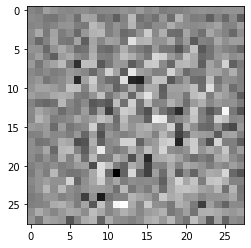

In [ ]:
generator = generator_model()

Noise = tf.random.normal([1, 100])
g_image = generator(Noise, training=False)

plt.imshow(g_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

The discriminator is a convolutional neural network based classifier.The discriminator model is the inverse version of the generator model

**Input for discriminator model:**output of generator model(28x28)pixel image

**Output**:produces an output of single value

**Target of discriminator**:Distinguish between real and fake images that are generated by the generator and minimize the overall loss function.

when the performance of the discriminator increase this affects negatively the generator cost.

The discriminator model using Keras Sequential API.


In [ ]:
def discriminator_model():

    

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',    
                                     input_shape=[28, 28, 1]))           #strides parameter controlling width and height
                                                                 # kernel size(5,5) is multiplied by the input to produce the output

    model.add(layers.LeakyReLU())                                #LeakyReLU activation used in all layers except last one(outer layer)

    model.add(layers.Dropout(0.3))                               #The Dropout layer randomly sets input units to 0 with a frequency of rate 
                                                                 #at each step during training time, which helps prevent overfitting
                                                                 #rate represents a Float between 0 and 1. Fraction of the input units to drop, in our
                                                                 #code it is 0.3


    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #Conv2DTranspose upsampling
                                                                          # kernel (5,5) ,128 represents filters
    model.add(layers.LeakyReLU())   
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten()) # Flatten class: flattens the input but does not affect the batch size.
                                #convert convolutional 2D layer into 1D of fully connected convolutional network

    model.add(layers.Dense(1))  
                                #Dense Layer is used to classify image based on output from convolutional layers

    return model

These simple lines of code  call the function to create our discriminator model

Then we want to check the discriminator decision about the sample generated by the generator

discriminator decision is o for fake images and 1 for real images

In [ ]:
discriminator = discriminator_model()
decision = discriminator(g_image)      #g_image represents the generated image
print (decision)

tf.Tensor([[0.00200136]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Here we  created  a Binary Crossentropy object from tf.keras.losses module and its target is to compute binary cross entropy.
The Binary cross entropy compares between predictions and actual output which shows how close or far are we from the actual value.

In [ ]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)      # from_logits=True means that the output values generated by the model are not normalized,
                                                                         

 Our discriminator loss is calculated as a 
combination of the discriminator’s predictions on real images to an array of ones and and the  predictions of discriminator on generated images to an array of zeros.


In [ ]:
def d_loss(Real, Fake):     #Real represents real output , Fake represents fake output , d_loss represents discriminator loss
    R_loss = cross_entropy(tf.ones_like(Real), Real)  # R_loss represents real loss 
                                                      #the discriminator’s predictions on real images represents an array of ones
                                                      #cross entropy shows how close or far are we from the actual value
                                                      
    F_loss = cross_entropy(tf.zeros_like(Fake), Fake)   #the predictions of discriminator on generated images represents array of zeros
    total_loss = R_loss + F_loss                        # total loss is calculated as real loss + fake loss
    return total_loss

The  generator loss is calculated by measuring how well it was able to deceive the discriminator. Then we need to compare the decisions of the discriminator on the generated images to an array of ones.

In [ ]:
def g_loss(Fake):                                     # g_loss represents generator loss   
    return cross_entropy(tf.ones_like(Fake), Fake)   #Fake represents fake output, decisions of discriminator on the generated images

Here we also make two optimizers one for generator and the other for the discriminator models

we also used Adam optimizer object from tf.keras.optimizers module


In [ ]:
g_optimizer = tf.keras.optimizers.Adam(1e-4)     # g_optimizer represents generator optimizer, (1e-4) is learning rate

                                                         #Adam optimizer is used to accelerate the gradient descent algorithm by taking into consideration 
                                                         #the 'exponentially weighted average of the gradients and reduce noise
                                                         #Adam is an adaptive learning rate optimization algorithm that has been designed specifically for training
                                                         # deep neural networks

d_optimizer = tf.keras.optimizers.Adam(1e-4)   # d_optimizer represents discriminator optimizer, (1e-4) learning rate

We set a checkpoint directory to be able to access previous training steps and to be able to save our work at each epoch. we used the os library to set a path to save all the training steps

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,                    #g_optimizer represents generator optimizer
                                                                             #d_optimizer represents discriminator optimizer
                                 d_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# this function is already implemented and ready to use in tensorflow

These below lines of code represents the training loop of our model  

In [ ]:
EPOCHS = 5                   # Epochs defines the number times that the learning algorithm will work through the entire training dataset 
Noise_dim = 100                  # represents samples 
num_examples_to_generate = 16    # generates a random array with normal distribution of  the shape (16, 100).


seed = tf.random.normal([num_examples_to_generate, Noise_dim])   #seed represents random noise
                      

The training procedure takes place with:

firstly the generator receive a random noise (seed) as input

secondly this seed is used to produce an image

thirdly The discriminator is then used to classify real images and fakes images

fourthly The loss is calculated for generator and discriminator models

**The gradients are used to update the generator and discriminator.**

In [ ]:


@tf.function                      # is an annotation causes the function to be compiled as part of the training
def train_step(images):         
    
    
                                                          
    Noise = tf.random.normal([BATCH_SIZE, Noise_dim])     #firstly the generator receive a random noise (seed) as input,BATCH_Size represents
                                                          # number of images trained in one epoch, Noise_dim represents samples

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:   # GradientTape method records operations for making differentiation automatically

                                                                                         #secondly this seed is used to produce an image

                                                                             


#thirdly The discriminator is then used to classify real images and fakes images

#fourthly The loss is calculated for generator and discriminator models 
                                                                             

      g_images = generator(Noise, training=True)         # g_images represents the generated images

      Real = discriminator(images, training=True)
      Fake = discriminator(g_images, training=True)

      generator_loss = g_loss(Fake)                   #generator_loss represents the loss after training of the model
                                                      # g_loss represents loss before training of the model
      disc_loss = d_loss(Real, Fake)      #Real represents real output and fake represents fake oputput



     
    #gradient perform automatic differentiation and update generator and discriminator

     
    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables) #gradient method computes the gradient using operations 
                                                                                                    #(generator_tape.gradient)
                                                                                                    #source variables  :generator.trainable_variables
                                                                                                    #target variables : generator_loss
                                                                                                    #target will be differentiated against elements of the source

    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)  # the same as the generator model
                                                                                                            #target(disc_loss) will be differentiated with sourse
                                                                                                            #( discriminator.trainable_variables)


     # Processing of the  Gradients and Running the Optimizer
     # "apply_gradients" method processes aggregated gradients. 
   

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))   # g_optimizer represents generator optimizer

   # By computing gradients using tape.gradient() the result is the gradient for weight and bias as list of lists
   #but  Zip  takes only the first values of both variables and zip them for the optimizer to minimize it

    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  #d_optimizer represents discriminator optimizer



During the Training:

record time spent at the beginning of each epoch

Save the model every 5 epochs as a checkpoint

Print out the completed epoch time

Generate a final image in the end of each epoch

This function generates and saves the images:

In [ ]:
import time
from IPython import display  #for interactive python computing

def train(dataset, epochs): 
  for epoch in range(epochs):   #for each epoch 
    start = time.time()
 
    for image_batch in dataset:  # For each batch of the epoch,run the usual train_step
      train_step(image_batch)

    # Produce images for the GIF 
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs as a checkpoint
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))  #Print out the completed epoch number and the time spent

  # Generate a final image after the final epoch() the training is completed)
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

This function generates and saves the images

In [ ]:
def generate_and_save_images(model, epoch, test_input):   #generate images
  
  predictions = model(test_input, training=False)
   
  fig = plt.figure(figsize=(4, 4))  #plot images

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))      #save the generated image
  plt.show()

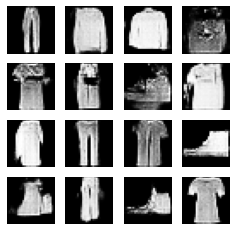

In [ ]:
train(t_dataset, EPOCHS)

Here we want to restore values from latest checkpoints before generating new images

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Display a single image using the epoch number

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))   #PIL library is a library that can open different image file formats

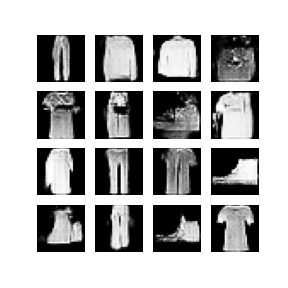

In [ ]:
display_image(EPOCHS)

Calculation of the inception score using keras

we used this link for calculation of the inception score
https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/

what is the inception score:
The Inception Score is one of the **quantitative metrics** that are used for evaluating the quality of generated images such as images output by generative adversarial network models.

The higher the inception score the better the quality of the generated images
**The higher the inception score the better the quality of the generated images**

**Inception score has some problems **such as favors memory GAN, fails to detect some bad trapping model, favors detectable objects rather than realistic, favors generator, asymmetric, affected by image resolution.




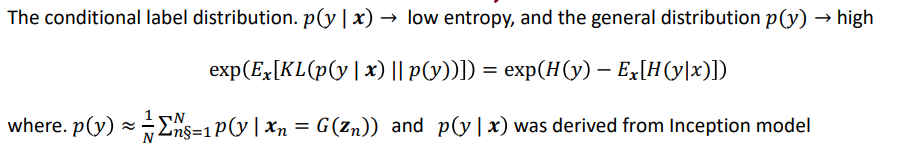

In [ ]:
from math import floor
import numpy
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from keras.datasets import fashion_mnist
from skimage.transform import resize
from scipy.linalg import sqrtm


In [ ]:
#This function is used for both IS and FID to fit the inception model
# firstly step: scaling  of  array of images to a new size
def ScalingImages(images, NewShape):   
	imageslist = list()
	for image in images:

# After rescaling ,resize it with nearest neighbor interpolation
		image = resize(image, NewShape, 0)        #image refers to new image after scaling
	
# storing data after resizing it with nearst interpolation
		imageslist.append(image)
	return asarray(imageslist)

In [ ]:
#Calculating the inception socre to evaluate the DCGAN model
# assuming that images have any shape and pixels in [0,255]
def calculate_InceptionScore(images, n_split=10, eps=1E-16):

	
	model = InceptionV3()         # loading inception version3 model
 
	# enumerate splits of predictions
	score = list()
	n_part = floor(images.shape[0] / n_split)
 
	for i in range(n_split):
		# retrieve of  images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		Subset = images[ix_start:ix_end]

		# from uint8 to float32
		Subset = Subset.astype('float32')
	
		# scaling images to the required size
		Subset = ScalingImages(Subset, (299,299,3))
	
		# preprocessing images, scale to [-1,1]
		Subset = preprocess_input(Subset)
	
		# prediction of the p(y|x)
		p_yx = model.predict(Subset)
	
		# calculation of p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
	
		# calculation of KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))        # Kl divergence quantifies how much one probability distribution differs from another probability distribution
	
		# sum over the classes
		sum_kl_d = kl_d.sum(axis=1)
	
		# average over images
		avg_kl_d = mean(sum_kl_d)
	
		# undo the log
		is_score = exp(avg_kl_d)
	
		# storing results
		score.append(is_score)
	
	# average across images
	is_avg, is_std = mean(score), std(score)
	return is_avg, is_std

# loading mnist dataset
(images, _), (_, _) = fashion_mnist.load_data()
images = images[:1000]


print('loaded', images.shape)

# calculating the inception score
is_avg, is_std = calculate_InceptionScore(images)
print('score', is_avg, is_std)

loaded (1000, 28, 28)
score 4.608303 0.25629947


FID Calculation using keras we used this source
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/


FID is one of the quantitative metrics for GAN evaluation.

It is the result of improvement of inception score model

The activations are always calculated for a collection of real and generated images (fake).

After that these activations are then summarized as a multivariate Gaussian and the distance between these two distributions is calculated using FID. 

It also Computes Wasserstein-2 distance between these two distribution

**The lower FID score indicates more realistic images which is equivalent to the statistical properties of real images.**

**FID Limits**
Assumes gaussian distribution,
Consistent with human judgement, 
more robust to noise than IS,
FID detect mode dropping,and
FID is sensitive to some artifact

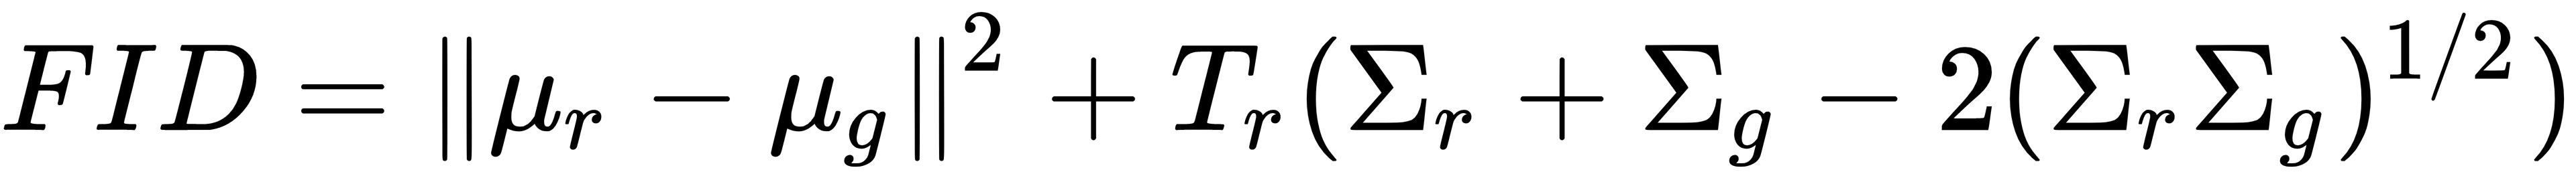

# calculation of the frechet inception distance in Keras

In [ ]:
#Calculation of frechet inception distance(FID)
def calculate_FID(model, images1, images2):

#activations calculation
	act1 = model.predict(images1)
	act2 = model.predict(images2)
 
#calculaion of mean and covariance
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
 
#calculation of square root of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))

# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real

#calculation of the score
	FID = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return FID

# preparation of the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

(images1, _), (images2, _) = fashion_mnist.load_data()

images1 = images1[:200]
images2 = images2[:200]

print('Loaded', images1.shape, images2.shape)

# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# resize images
images1 = ScalingImages(images1, (299,299,3))
images2 = ScalingImages(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# calculate FID
FID = calculate_FID(model, images1, images2)
print('FID: %.3f' % FID)

Loaded (200, 28, 28) (200, 28, 28)
Scaled (200, 299, 299, 3) (200, 299, 299, 3)
FID: 69.687
